In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.manova import MANOVA
import matplotlib.pyplot as plt
import seaborn as sns
import os


--- 步骤1：创建适用于多元回归的合成数据 ---
数据预览:
      ID        Long        Lat  Typhoon_Intensity  Cooling_Load  \
0  66200  123.539174  -1.624445           5.085913      9.521863   
1  44527   -3.036673  59.160593           2.761515      0.000000   
2  38794   17.524436  42.748798           2.789606      4.026352   
3  69834  120.346870   5.223677           9.748912      8.434261   
4  40027   -1.298564  50.674952           2.120981      0.000000   

   Heating_Load  LNG_Usage  Energy_Storage_Capacity  
0      1.188125   2.692978                 2.450621  
1      7.536874   5.087439                 1.850249  
2      4.995628   4.990258                 3.230009  
3      0.000000   2.209119                 3.730654  
4      4.169284   4.475495                 1.118499  

--- 步骤2：执行MANOVA和OLS回归 ---

--- MANOVA 检验结果摘要 ---
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       

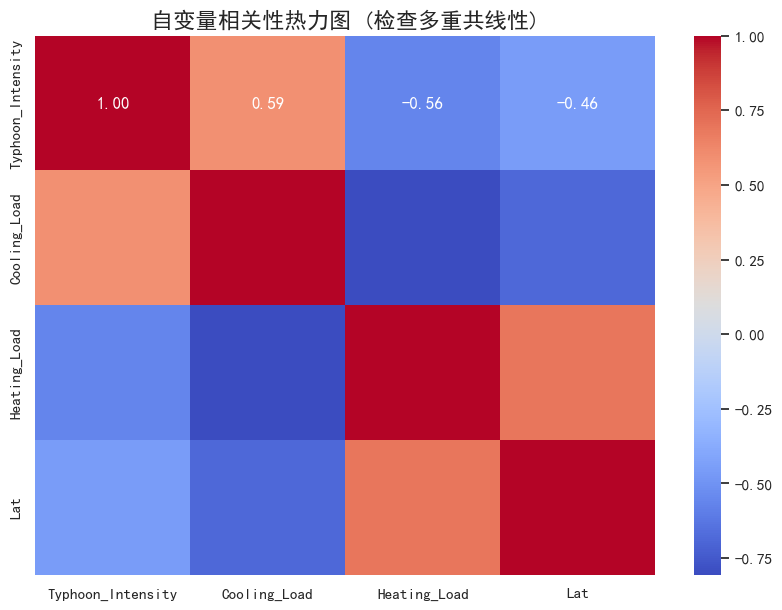

C:\Users\18130\AppData\Local\Temp\ipykernel_32520\38252376.py:174: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
d:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


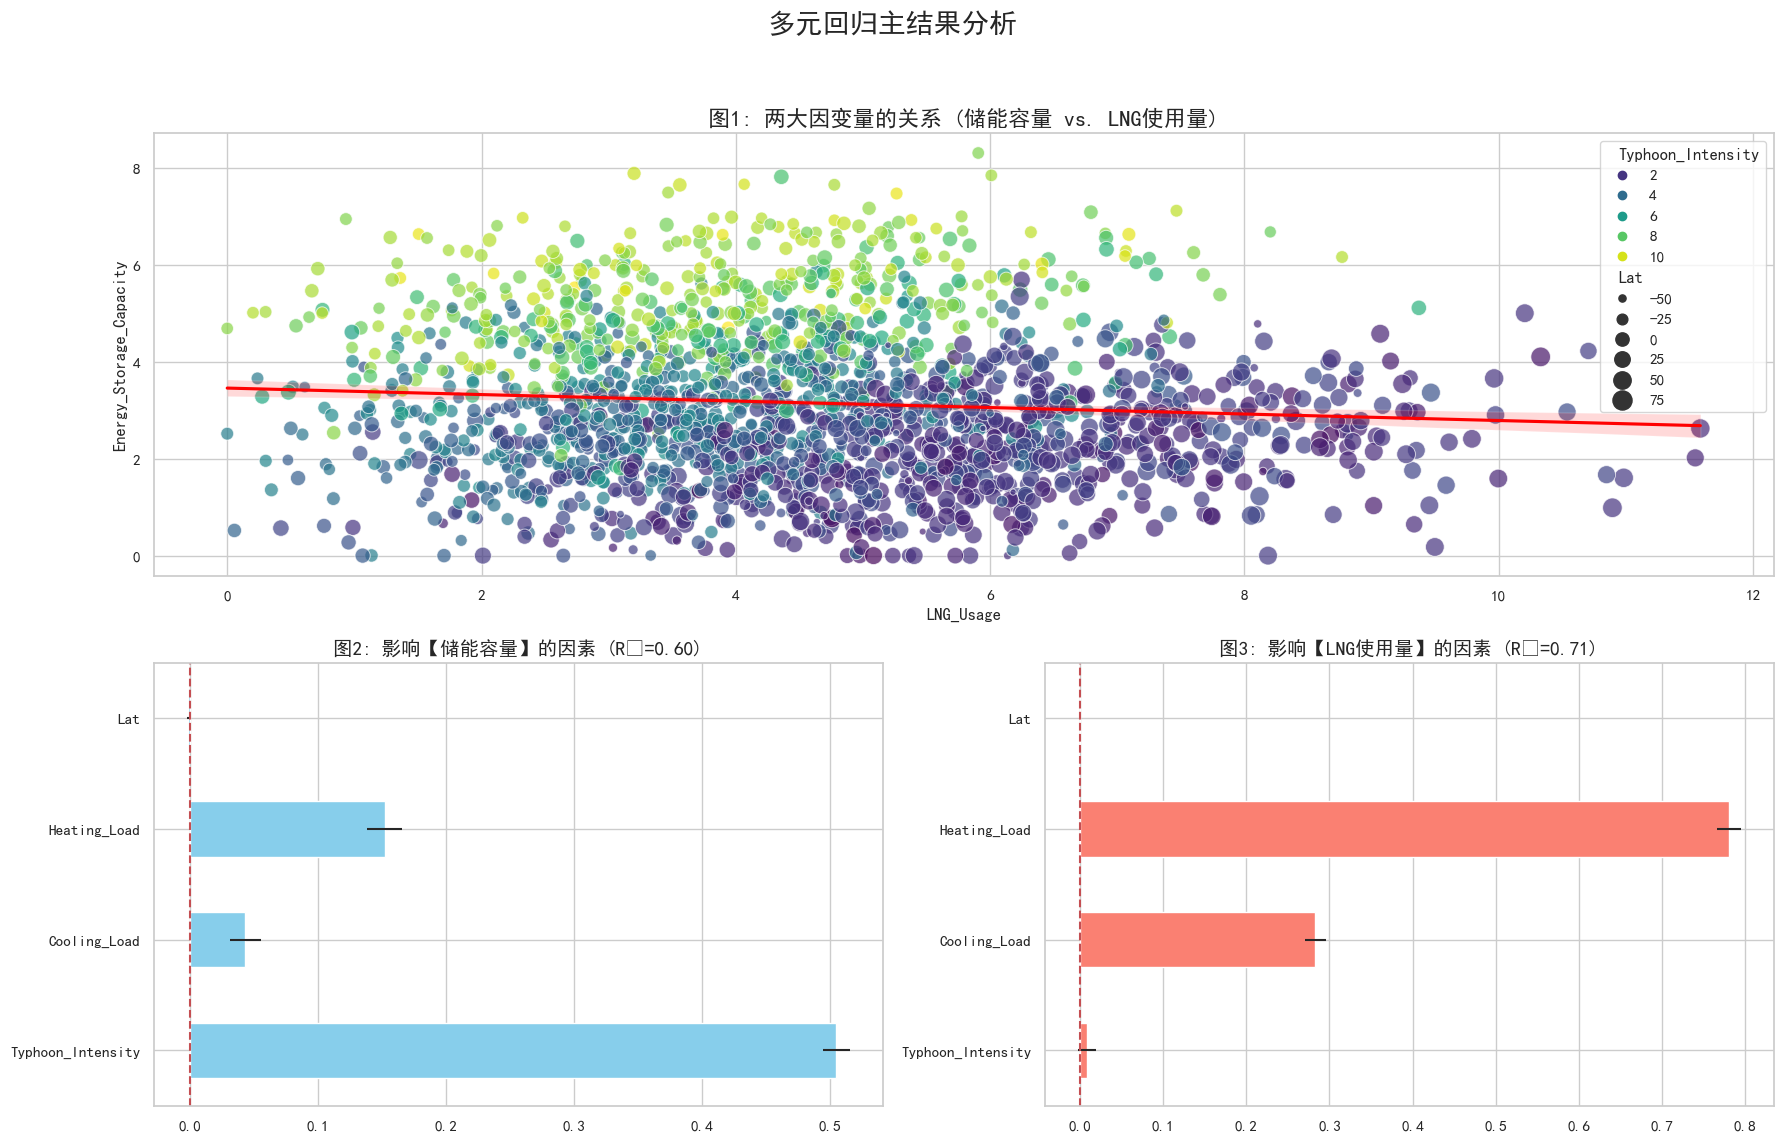

C:\Users\18130\AppData\Local\Temp\ipykernel_32520\38252376.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = 1 # VIF需要截距项



--- 步骤4：对每个模型进行详细的诊断检验 ---

模型诊断检验: 【Energy_Storage_Capacity】

--- 1. 多重共线性检验 (VIF) ---
方差膨胀因子 (VIF)。通常认为VIF > 5-10 存在共线性问题。
             feature        VIF
0  Typhoon_Intensity   1.580452
1       Cooling_Load   3.367211
2       Heating_Load   3.248270
3                Lat   2.110889
4          Intercept  27.488242

--- 2. 生成诊断四联图 ---


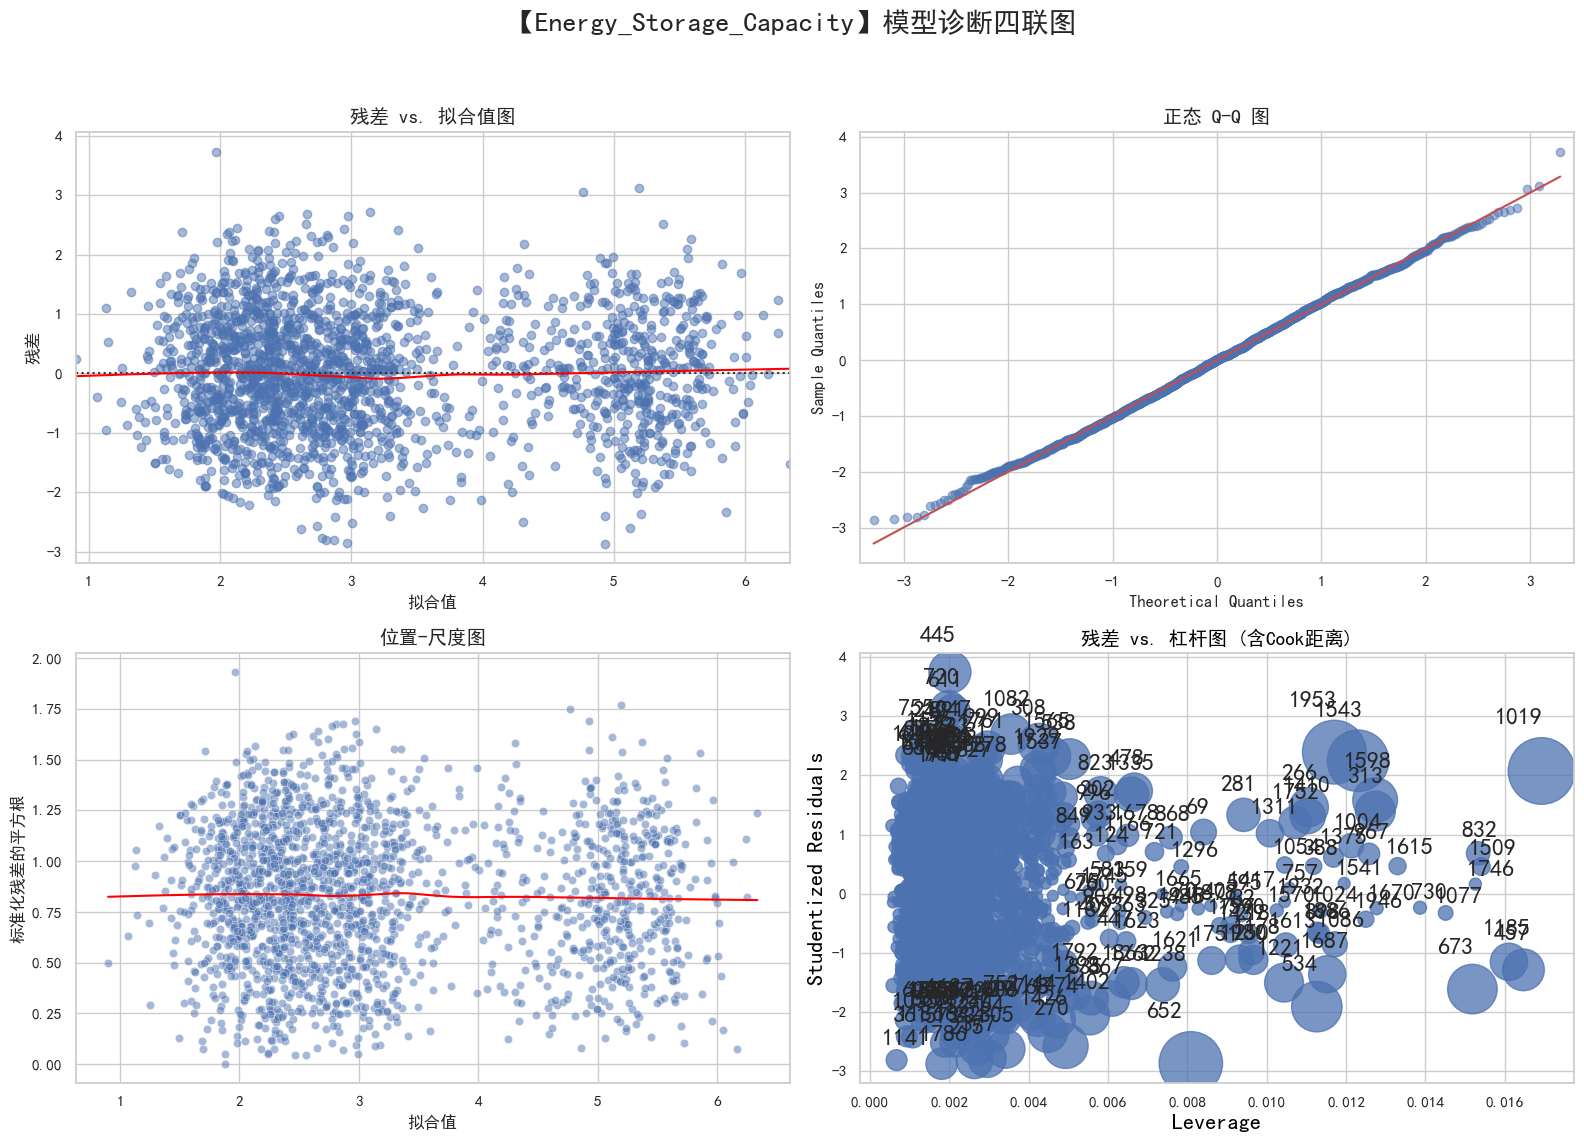


--- 3. 生成成分+残差图 (CCPR) ---
此图检查每个自变量与因变量的线性关系是否成立。


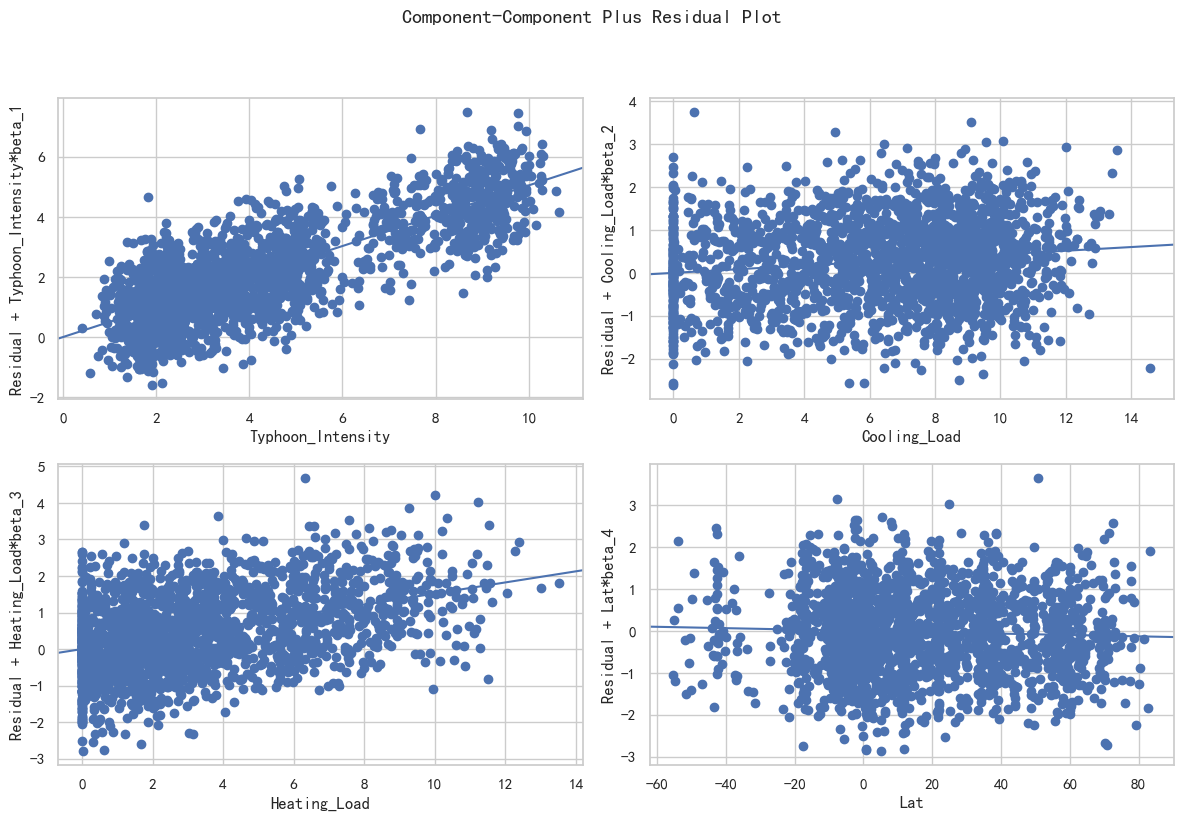


模型诊断检验: 【LNG_Usage】

--- 1. 多重共线性检验 (VIF) ---
方差膨胀因子 (VIF)。通常认为VIF > 5-10 存在共线性问题。
             feature        VIF
0  Typhoon_Intensity   1.580452
1       Cooling_Load   3.367211
2       Heating_Load   3.248270
3                Lat   2.110889
4          Intercept  27.488242

--- 2. 生成诊断四联图 ---


C:\Users\18130\AppData\Local\Temp\ipykernel_32520\38252376.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = 1 # VIF需要截距项


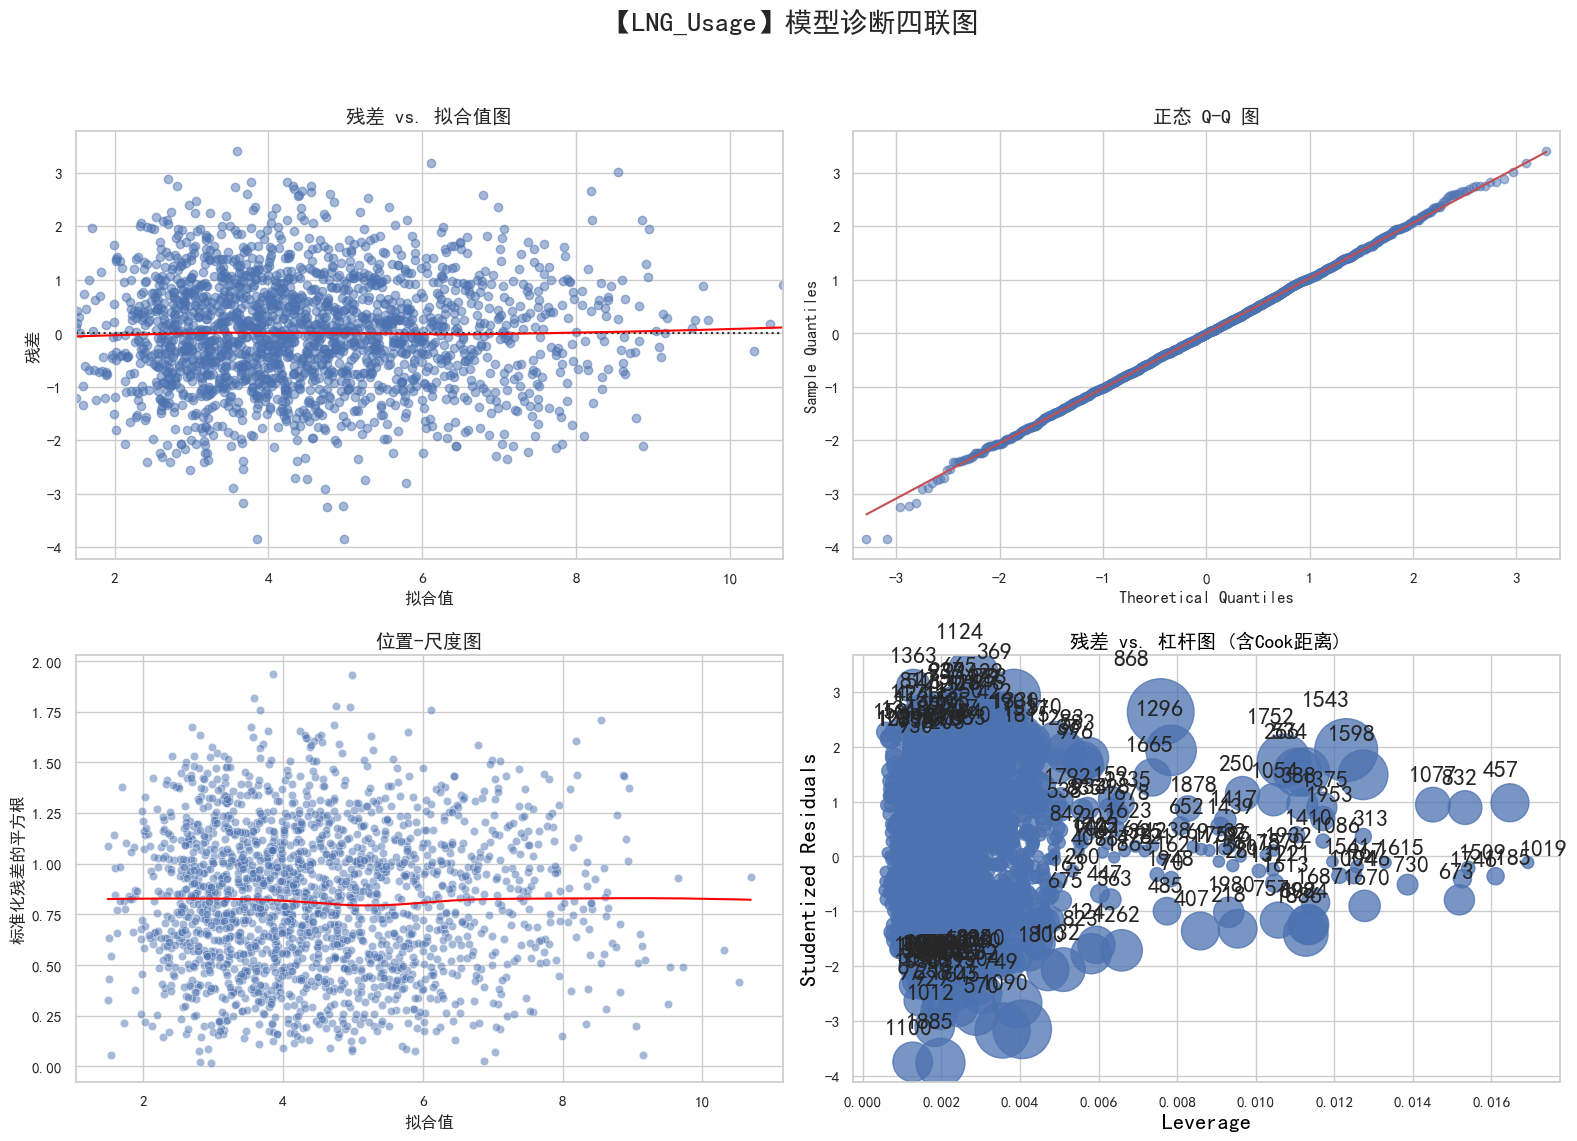


--- 3. 生成成分+残差图 (CCPR) ---
此图检查每个自变量与因变量的线性关系是否成立。


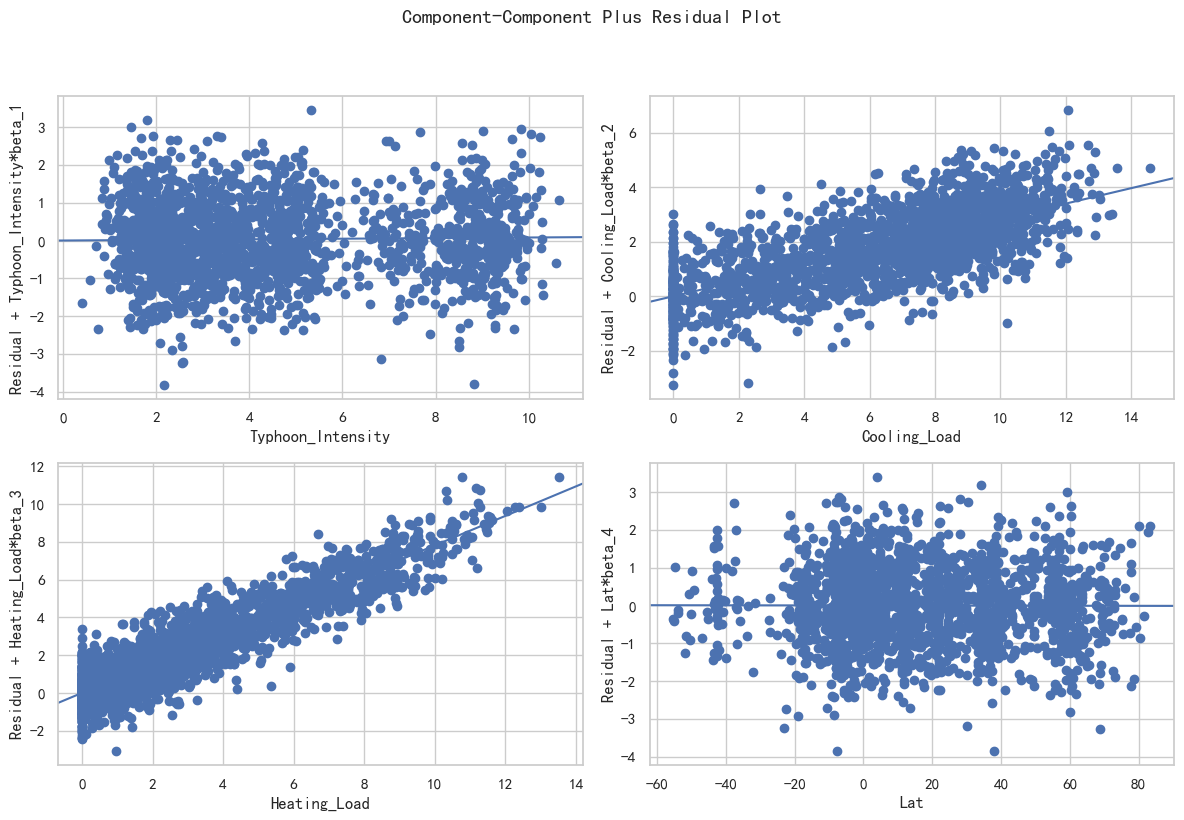


--- 分析流程结束 ---


In [13]:
"""
【最终版 V3 - 包含完整诊断检验】
本代码在V2的基础上，增加了完整的模型合理性检验，包括：
1.  多重共线性检验 (VIF) 与相关性热力图。
2.  为每个独立回归模型生成经典的诊断四联图。
3.  为每个独立回归模型生成成分+残差图 (CCPR plots)。
"""

# --- 第1步：创建合成数据 (逻辑不变) ---
np.random.seed(42)

def create_synthetic_data_v2(island_data_path):
    islands_df = pd.read_csv(island_data_path)
    if len(islands_df) > 2000:
        islands_df = islands_df.sample(2000, random_state=42).reset_index(drop=True)
    
    n = len(islands_df)
    typhoon_intensity = np.zeros(n)
    cooling_load = np.zeros(n)
    heating_load = np.zeros(n)

    for i, island in islands_df.iterrows():
        lat, lon = island['Lat'], island['Long']
        in_west_pacific = (lon > 115) and (lon < 160) and (abs(lat) < 30) and (abs(lat) > 5)
        in_west_atlantic = (lon > -100) and (lon < -60) and (lat > 10) and (lat < 30)
        base_intensity = 2.0 + (5.0 if in_west_pacific else 0) + (4.0 if in_west_atlantic else 0)
        lat_factor = 3.0 * (1 - abs(lat) / 30) if abs(lat) < 30 else 0
        typhoon_intensity[i] = max(0, base_intensity + lat_factor + np.random.normal(0, 0.5))
        cooling_load[i] = max(0, 10 * (1 - abs(lat)/60) + np.random.normal(0, 1.5))
        heating_load[i] = max(0, 8 * (abs(lat)/60) + np.random.normal(0, 1.5))

    lng_usage = np.zeros(n)
    energy_storage = np.zeros(n)
    
    for i in range(n):
        lng_usage[i] = max(0, 0.8 * heating_load[i] + 0.3 * cooling_load[i] + np.random.normal(0, 1))
        energy_storage[i] = max(0, 0.5 * typhoon_intensity[i] + 0.2 * lng_usage[i] + np.random.normal(0, 1))

    analysis_df = islands_df[['ID', 'Long', 'Lat']].copy()
    analysis_df['Typhoon_Intensity'] = typhoon_intensity
    analysis_df['Cooling_Load'] = cooling_load
    analysis_df['Heating_Load'] = heating_load
    analysis_df['LNG_Usage'] = lng_usage
    analysis_df['Energy_Storage_Capacity'] = energy_storage
    
    return analysis_df

# --- 第2步：执行MANOVA和OLS回归 (逻辑不变) ---
def perform_manova_analysis(df):
    iv_formula_part = 'Typhoon_Intensity + Cooling_Load + Heating_Load + Lat'
    manova_formula = f'Energy_Storage_Capacity + LNG_Usage ~ {iv_formula_part}'
    manova_model = MANOVA.from_formula(manova_formula, data=df)
    manova_results = manova_model.mv_test()
    
    ols_storage_formula = f'Energy_Storage_Capacity ~ {iv_formula_part}'
    ols_storage_model = sm.OLS.from_formula(ols_storage_formula, data=df).fit()
    
    ols_lng_formula = f'LNG_Usage ~ {iv_formula_part}'
    ols_lng_model = sm.OLS.from_formula(ols_lng_formula, data=df).fit()
    
    individual_results = {
        'Energy_Storage_Capacity': ols_storage_model,
        'LNG_Usage': ols_lng_model
    }
    
    return manova_results, individual_results

# --- 新增步骤：执行并可视化所有诊断检验 ---
def perform_and_visualize_diagnostics(model_results, model_name, df, iv_list):
    """
    对单个OLS模型执行完整的诊断检验并可视化。
    """
    print(f"\n{'='*60}")
    print(f"模型诊断检验: 【{model_name}】")
    print(f"{'='*60}")

    # 1. 多重共线性检验 (VIF)
    print("\n--- 1. 多重共线性检验 (VIF) ---")
    X = df[iv_list]
    X['Intercept'] = 1 # VIF需要截距项
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print("方差膨胀因子 (VIF)。通常认为VIF > 5-10 存在共线性问题。")
    print(vif_data)
    
    # 2. 诊断四联图
    print("\n--- 2. 生成诊断四联图 ---")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'【{model_name}】模型诊断四联图', fontsize=20)
    
    # 获取诊断所需数据
    fitted_vals = model_results.fittedvalues
    residuals = model_results.resid
    student_resid = model_results.get_influence().resid_studentized_internal
    leverage = model_results.get_influence().hat_matrix_diag
    
    # 2.1 残差 vs. 拟合值
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
                  ax=axes[0, 0], scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1.5})
    axes[0, 0].set_title('残差 vs. 拟合值图', fontsize=14)
    axes[0, 0].set_xlabel('拟合值', fontsize=12)
    axes[0, 0].set_ylabel('残差', fontsize=12)

    # 2.2 正态 Q-Q 图
    sm.qqplot(residuals, line='s', ax=axes[0, 1], alpha=0.5)
    axes[0, 1].set_title('正态 Q-Q 图', fontsize=14)

    # 2.3 位置-尺度图
    sqrt_student_resid = np.sqrt(np.abs(student_resid))
    sns.scatterplot(x=fitted_vals, y=sqrt_student_resid, ax=axes[1, 0], alpha=0.5)
    sns.regplot(x=fitted_vals, y=sqrt_student_resid, scatter=False, ci=False, lowess=True,
                line_kws={'color': 'red', 'lw': 1.5}, ax=axes[1, 0])
    axes[1, 0].set_title('位置-尺度图', fontsize=14)
    axes[1, 0].set_xlabel('拟合值', fontsize=12)
    axes[1, 0].set_ylabel('标准化残差的平方根', fontsize=12)

    # 2.4 残差 vs. 杠杆图
    sm.graphics.influence_plot(model_results, ax=axes[1, 1], criterion='cooks')
    axes[1, 1].set_title('残差 vs. 杠杆图 (含Cook距离)', fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 3. 成分+残差图 (CCPR Plots)
    print("\n--- 3. 生成成分+残差图 (CCPR) ---")
    print("此图检查每个自变量与因变量的线性关系是否成立。")
    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(f'【{model_name}】模型成分+残差图', fontsize=20)
    sm.graphics.plot_ccpr_grid(model_results, fig=fig)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 第3步：可视化结果 (主结果+EDA) ---
def create_visualizations(df, ind_results, iv_list):
    sns.set(style="whitegrid")
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 1. EDA: 自变量相关性热力图
    plt.figure(figsize=(10, 7))
    corr_matrix = df[iv_list].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('自变量相关性热力图 (检查多重共线性)', fontsize=16)
    plt.show()

    # 2. MANOVA主结果可视化
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2)
    fig.suptitle('多元回归主结果分析', fontsize=20)

    ax1 = fig.add_subplot(gs[0, :])
    sns.scatterplot(data=df, x='LNG_Usage', y='Energy_Storage_Capacity', hue='Typhoon_Intensity', size='Lat', sizes=(20, 200), palette='viridis', alpha=0.7, ax=ax1)
    sns.regplot(data=df, x='LNG_Usage', y='Energy_Storage_Capacity', scatter=False, color='red', ax=ax1)
    ax1.set_title('图1: 两大因变量的关系 (储能容量 vs. LNG使用量)', fontsize=16)
    
    ax2 = fig.add_subplot(gs[1, 0])
    res_storage = ind_results['Energy_Storage_Capacity']
    coef_storage = res_storage.params.drop('Intercept')
    err_storage = res_storage.bse.drop('Intercept')
    coef_storage.plot(kind='barh', xerr=err_storage, ax=ax2, color='skyblue')
    ax2.set_title(f'图2: 影响【储能容量】的因素 (R²={res_storage.rsquared_adj:.2f})', fontsize=14)
    ax2.axvline(x=0, color='r', linestyle='--')

    ax3 = fig.add_subplot(gs[1, 1])
    res_lng = ind_results['LNG_Usage']
    coef_lng = res_lng.params.drop('Intercept')
    err_lng = res_lng.bse.drop('Intercept')
    coef_lng.plot(kind='barh', xerr=err_lng, ax=ax3, color='salmon')
    ax3.set_title(f'图3: 影响【LNG使用量】的因素 (R²={res_lng.rsquared_adj:.2f})', fontsize=14)
    ax3.axvline(x=0, color='r', linestyle='--')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 主执行函数 ---
def main():
    island_data_file = 'island_cost_data.csv'
    
    print("\n--- 步骤1：创建适用于多元回归的合成数据 ---")
    analysis_df = create_synthetic_data_v2(island_data_file)
    print("数据预览:")
    print(analysis_df.head())
    
    print("\n--- 步骤2：执行MANOVA和OLS回归 ---")
    manova_results, individual_results = perform_manova_analysis(analysis_df)
    
    print("\n--- MANOVA 检验结果摘要 ---")
    print(manova_results)
    print("\n--- 单独回归模型摘要 (储能容量) ---")
    print(individual_results['Energy_Storage_Capacity'].summary())
    print("\n--- 单独回归模型摘要 (LNG使用量) ---")
    print(individual_results['LNG_Usage'].summary())
    
    print("\n--- 步骤3：生成主结果和EDA可视化图表 ---")
    iv_list = ['Typhoon_Intensity', 'Cooling_Load', 'Heating_Load', 'Lat']
    create_visualizations(analysis_df, individual_results, iv_list)
    
    print("\n--- 步骤4：对每个模型进行详细的诊断检验 ---")
    for name, model in individual_results.items():
        perform_and_visualize_diagnostics(model, name, analysis_df, iv_list)
    
    print("\n--- 分析流程结束 ---")

if __name__ == "__main__":
    main()